In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib.patches as mpatches

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'code')
from help_funcs import *

In [3]:
import matplotlib

matplotlib.rcParams.update({'font.size': 18})

In [68]:
def periodic_distance(p1, p2, L=1.0):
    """
    Calculates the periodic distance between two points on a 1x1 2-dimensional plane.

    Parameters
    ----------
    p1 : numpy array
        The first point, with shape (2,).
    p2 : numpy array
        The second point, with shape (2,).
    L : float
        The length of the periodic boundary, default value is 1.0.

    Returns
    -------
    distance : float
        The periodic distance between two points.
    """
    delta = np.abs(p1 - p2)
    delta = np.where(delta > L/2, L - delta, delta)
    return np.sqrt(np.sum(delta**2))

import scipy.stats
def getStimRateMeans(exc_spikes, exc_positions, rates=False, nsecs = 5, binlen = 100):
    # store the control times and the chr2 stimulation times
    control_times = []
    chr_times = []
    ii = 0
    is_control = True
    while True:
        start_time = ii * 500 + 1000
        stop_time = start_time + binlen
        if stop_time > nsecs*1000: break
        if is_control:
            control_times.append(start_time)
        else:
            chr_times.append(start_time)   
        ii += 1
        if is_control:
            is_control = False
        else:
            is_control = True        
        
    assert len(control_times) == len(chr_times)
#     print("NTIMES:", control_times, chr_times)
    # compute the rates of the cells distal to the chr2 stimulus
    control_spikes = []
    chr_spikes = []
    center_pos = np.array([0.5,0.5])
    for ni in range(len(exc_positions)):
        pos_x, pos_y = exc_positions[ni,:]
        dist = np.sqrt((0.5-pos_x)**2 + (0.5-pos_y)**2)
        if dist > 0.25:
            continue
        nspikes = 0
        for tim in control_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        control_spikes.append(nspikes)

        nspikes = 0
        for tim in chr_times:
            aa = exc_spikes[ni] [exc_spikes[ni] > tim ]
            aa = aa [aa < tim+binlen]
            nspikes += len(aa)
        chr_spikes.append(nspikes)
    control_rates = np.divide(control_spikes,(binlen/1000)*len(control_times)) # convert from spike count to rate
    chr_rates = np.divide(chr_spikes,(binlen/1000)*len(chr_times))
    ctrl_mean = np.mean(control_rates)
    chr2_mean = np.mean(chr_rates)
    
    ctrl_err = scipy.stats.sem(control_rates)
    chr2_err = scipy.stats.sem(chr_rates)
    
    if rates:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err, control_rates, chr_rates]
    else:
        return [ctrl_mean, chr2_mean, ctrl_err, chr2_err]
    

def getSpontMedians(all_spikes, start_time = 1000., stop_time = 10000.):
    
    exc_spikes = all_spikes[:8000]
    pv_spikes = all_spikes[8000:9000]
    sst_spikes = all_spikes[9000:]
    
    tlen = (stop_time - start_time)/1000.
    
    exc_nspikes = []
    for spikes in exc_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        exc_nspikes.append(len(aa)/tlen)
        
    pv_nspikes = []
    for spikes in pv_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        pv_nspikes.append(len(aa)/tlen)
        
    sst_nspikes = []
    for spikes in sst_spikes:
        aa = spikes[spikes > start_time ]
        aa = aa [aa < stop_time]
        sst_nspikes.append(len(aa)/tlen)
        
    return np.median(exc_nspikes), np.median(pv_nspikes), np.median(sst_nspikes)

In [69]:
import numpy as np
from scipy.optimize import curve_fit

# naka-rushton = (m+((Rm.*(x.^n))./((x.^n) + (c50.^n)))))
# parameter = [Rm, n, c50, m]
# p0 = [150, 5, 0.1, 50]
# Upper = [250, 30, 0.26, 200]
# Lower = [0, 0, 0.04, 0]
p0 = [50, 150, 5, 0.1] 
Upper = [200, 250, 15, 0.2]
# Lower = [0, 0, 0, 0.04]
Lower = [0, 0, 0, 0.05]
bounds = (Lower, Upper)

def naka_rushton(x, m, C, n, k):
    return m + C * (x**n) / (x**n + k**n)

def fit_naka_rushton(x, y, sigma=None, p0 = p0, bounds=bounds):
    params, cov = curve_fit(naka_rushton, x, y, bounds=bounds, sigma=sigma, p0=p0, maxfev = 1000000)
    return params, cov


# def naka_rushton(x, m, C, n):
#     return m + C * (x**n) / (x**n + 0.1**n)

# def fit_naka_rushton(x, y, sigma=None, p0 = [4., 2.0, 2.0]):
#     params, cov = curve_fit(naka_rushton, x, y, sigma=sigma, p0=p0, maxfev = 1000000)
#     return params, cov

# x = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
# y = np.array([0.1, 0.15, 0.3, 0.6, 0.8])

# C, n, k = fit_naka_rushton(contrasts, y)
# print("C =", C)
# print("n =", n)
# print("k =", k)


In [70]:
def get_slope(m,C,n,k):
    cvals = np.arange(0.02,0.33,0.01)
    yvals = naka_rushton(cvals, m, C, n, k)
    
    slopes = []
    for i in range(1, len(cvals)):
        slopes.append((yvals[i]-yvals[i-1])/0.01)
    maxslope = np.max(slopes)
    return maxslope, cvals[slopes.index(maxslope)]

In [ ]:
simname = 'base3t'
contrasts = np.array([0.02, 0.05, 0.1, 0.18, 0.33])
# contrasts = np.array([0.02, 0.05, 0.1, 0.18])
ignor=0
slopes_cp, slopes_sp, slopes_cs, slopes_ss = [], [], [], []
binlen = 60

ctrl_pv_ave = np.zeros(5)
stim_pv_ave = np.zeros(5)
ctrl_sst_ave = np.zeros(5)
stim_sst_ave = np.zeros(5)

parameter_fits = []

for seed in range(1,101):
    # contrasts = np.array([0.02, 0.05, 0.2, 0.3])
    # contrasts = np.array([0.02,  0.2])
    ctrl_pv_curve = [[] for i in range(4)]
    stim_pv_curve = [[] for i in range(4)]
    ctrl_sst_curve = [[] for i in range(4)]
    stim_sst_curve = [[] for i in range(4)]

    ctrl_pv_curve_e = [[] for i in range(4)]
    stim_pv_curve_e = [[] for i in range(4)]
    ctrl_sst_curve_e = [[] for i in range(4)]
    stim_sst_curve_e = [[] for i in range(4)]

    
    folder = 'data/%s/results_%s/'%(simname, seed)
    not_all_found=False
    for ci, cont in enumerate(contrasts):
        try:
            with open(folder + 'PV_%s_spikes.pickle'%cont, 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'PV_%s_positions.pickle'%cont, 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            break

        ctrlpv_E_mean, stimpv_E_mean, ctrlpv_E_err, stimpv_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen=binlen)
        ctrlpv_P_mean, stimpv_P_mean, ctrlpv_P_err, stimpv_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen=binlen)
        ctrlpv_S_mean, stimpv_S_mean, ctrlpv_S_err, stimpv_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen=binlen)
        ctrlpv_A_mean, stimpv_A_mean, ctrlpv_A_err, stimpv_A_err = getStimRateMeans(all_spikes, all_positions, binlen=binlen)

        ctrl_pv_curve[0].append(ctrlpv_E_mean)
        ctrl_pv_curve[1].append(ctrlpv_P_mean)
        ctrl_pv_curve[2].append(ctrlpv_S_mean)
        ctrl_pv_curve[3].append(ctrlpv_A_mean)
        ctrl_pv_curve_e[0].append(ctrlpv_E_err)
        ctrl_pv_curve_e[1].append(ctrlpv_P_err)
        ctrl_pv_curve_e[2].append(ctrlpv_S_err)
        ctrl_pv_curve_e[3].append(ctrlpv_A_err)

        stim_pv_curve[0].append(stimpv_E_mean)
        stim_pv_curve[1].append(stimpv_P_mean)
        stim_pv_curve[2].append(stimpv_S_mean)
        stim_pv_curve[3].append(stimpv_A_mean)
        stim_pv_curve_e[0].append(stimpv_E_err)
        stim_pv_curve_e[1].append(stimpv_P_err)
        stim_pv_curve_e[2].append(stimpv_S_err)
        stim_pv_curve_e[3].append(stimpv_A_err)
        


        try:
            with open(folder + 'SOM_%s_spikes.pickle'%cont, 'rb') as f:
                all_spikes = pickle.load(f)
            with open(folder + 'SOM_%s_positions.pickle'%cont, 'rb') as f:
                all_positions = pickle.load(f)
        except FileNotFoundError:
            not_all_found = True
            break

        ctrlsst_E_mean, stimsst_E_mean, ctrlsst_E_err, stimsst_E_err = getStimRateMeans(all_spikes[:8000], all_positions[:8000], binlen= binlen)
        ctrlsst_P_mean, stimsst_P_mean, ctrlsst_P_err, stimsst_P_err = getStimRateMeans(all_spikes[8000:9000], all_positions[8000:9000], binlen= binlen)
        ctrlsst_S_mean, stimsst_S_mean, ctrlsst_S_err, stimsst_S_err = getStimRateMeans(all_spikes[9000:10000], all_positions[9000:10000], binlen= binlen)
        ctrlsst_A_mean, stimsst_A_mean, ctrlsst_A_err, stimsst_A_err = getStimRateMeans(all_spikes, all_positions, binlen= binlen)


        ctrl_sst_curve[0].append(ctrlsst_E_mean)
        ctrl_sst_curve[1].append(ctrlsst_P_mean)
        ctrl_sst_curve[2].append(ctrlsst_S_mean)
        ctrl_sst_curve[3].append(ctrlsst_A_mean)
        ctrl_sst_curve_e[0].append(ctrlsst_E_err)
        ctrl_sst_curve_e[1].append(ctrlsst_P_err)
        ctrl_sst_curve_e[2].append(ctrlsst_S_err)
        ctrl_sst_curve_e[3].append(ctrlsst_A_err)

        stim_sst_curve[0].append(stimsst_E_mean)
        stim_sst_curve[1].append(stimsst_P_mean)
        stim_sst_curve[2].append(stimsst_S_mean)
        stim_sst_curve[3].append(stimsst_A_mean)
        stim_sst_curve_e[0].append(stimsst_E_err)
        stim_sst_curve_e[1].append(stimsst_P_err)
        stim_sst_curve_e[2].append(stimsst_S_err)
        stim_sst_curve_e[3].append(stimsst_A_err)
    # contrasts = np.array([ 0.05, 0.1, 0.2, 0.3])
    
        ctrl_pv_ave[ci] += ctrlpv_A_mean
        stim_pv_ave[ci] += stimpv_A_mean
        ctrl_sst_ave[ci] += ctrlsst_A_mean
        stim_sst_ave[ci] += stimsst_A_mean
    
    if not_all_found:
        continue
    continue
        
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_pv_curve[3][ignor:], sigma=ctrl_pv_curve_e[3][ignor:])
    m_cp, C_cp, n_cp, k_cp = params
    m_cp_err, C_cp_err, n_cp_err, k_cp_err = np.sqrt(np.diag(cov))
#     slope_cp = C_cp*n_cp/k_cp/4.0
    slope_cp, _ = get_slope(m_cp, C_cp, n_cp, k_cp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_pv_curve[3][ignor:], sigma=stim_pv_curve_e[3][ignor:])
    m_sp, C_sp, n_sp, k_sp = params
    m_sp_err, C_sp_err, n_sp_err, k_sp_err = np.sqrt(np.diag(cov))
#     slope_sp = C_sp*n_sp/k_sp/4.0
    slope_sp, _ = get_slope(m_sp, C_sp, n_sp, k_sp)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], ctrl_sst_curve[3][ignor:], sigma=ctrl_sst_curve_e[3][ignor:])
    m_cs, C_cs, n_cs, k_cs = params
    m_cs_err, C_cs_err, n_cs_err, k_cs_err = np.sqrt(np.diag(cov))
#     slope_cs = C_cs*n_cs/k_cs/4.0
    slope_cs, _ = get_slope(m_cs, C_cs, n_cs, k_cs)
    
    params, cov = fit_naka_rushton(contrasts[ignor:], stim_sst_curve[3][ignor:], sigma=stim_sst_curve_e[3][ignor:])
    m_ss, C_ss, n_ss, k_ss = params
    m_ss_err, C_ss_err, n_ss_err, k_ss_err = np.sqrt(np.diag(cov))
#     slope_ss = C_ss*n_ss/k_ss/4.0
    slope_ss, _ = get_slope(m_ss, C_ss, n_ss, k_ss)
    
    
#     if np.max( [slope_cp, slope_sp, slope_cs, slope_ss] ) >50: continue
    slopes_cp.append(slope_cp)
    slopes_sp.append(slope_sp)
    slopes_cs.append(slope_cs)
    slopes_ss.append(slope_ss)
    
    print(m_ss, C_ss, n_ss, k_ss)
    parameter_fits.append([ m_cp, C_cp, n_cp, k_cp, m_sp, C_sp, n_sp, k_sp, m_cs, C_cs, n_cs, k_cs, m_ss, C_ss, n_ss, k_ss])
    
    print(slope_cp, slope_sp, slope_cs, slope_ss, np.max( [slope_cp, slope_sp, slope_cs, slope_ss] ) )
    
    scal = 50
    cvals = np.arange(0.02,0.33,0.001)
    fig,axes = plt.subplots(1,2,figsize = (8,4))
    axes[0].scatter(contrasts*100, np.array(ctrl_pv_curve[3])*scal, c='black')
    axes[0].scatter(contrasts*100, np.array(stim_pv_curve[3])*scal, c='blue')
    yvals = naka_rushton(cvals, m_cp, C_cp, n_cp, k_cp)
    axes[0].plot(cvals*100, yvals*scal, c='black')
    yvals = naka_rushton(cvals, m_sp, C_sp, n_sp, k_sp)
    axes[0].plot(cvals*100, yvals*scal, c='blue')
    
    axes[1].scatter(contrasts*100, np.array(ctrl_sst_curve[3])*scal, c='black')
    axes[1].scatter(contrasts*100, np.array(stim_sst_curve[3])*scal, c='orange')
    yvals = naka_rushton(cvals, m_cs, C_cs, n_cs, k_cs)
    axes[1].plot(cvals*100, yvals*scal, c='black')
    yvals = naka_rushton(cvals, m_ss, C_ss, n_ss, k_ss)
    axes[1].plot(cvals*100, yvals*scal, c='orange')
    plt.suptitle(seed)
    plt.show()
    
    print(seed)
    
ctrl_pv_ave = ctrl_pv_ave/100.
stim_pv_ave = stim_pv_ave/100.
ctrl_sst_ave = ctrl_sst_ave/100.
stim_sst_ave = stim_sst_ave/100.

In [ ]:
with open('parameter_fits_base3t.pickle', 'wb') as f:
    pickle.dump(parameter_fits, f)

In [42]:
with open('parameter_fits_base3t.pickle', 'rb') as f:
    parameter_fits = pickle.load(f)

In [9]:
len(parameter_fits)

100

In [23]:
sstcolor = (0.898,0.6314,0.0039)
pvcolor = (0.0, 0.4039, 0.7059)

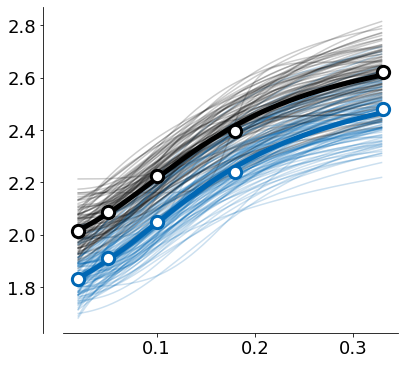

In [58]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (6,6))
cvals = np.arange(0.02,0.33,0.001)
ctrlave = np.zeros(len(cvals))
stimave = np.zeros(len(cvals))
for ti in range(100):
    m_cp, C_cp, n_cp, k_cp, m_sp, C_sp, n_sp, k_sp, m_cs, C_cs, n_cs, k_cs, m_ss, C_ss, n_ss, k_ss = parameter_fits[ti]

    
    yvals = naka_rushton(cvals, m_cp, C_cp, n_cp, k_cp)

    ax.plot(cvals,yvals, c= 'black', alpha=0.2)
    
    ctrlave += yvals
    
    cvals = np.arange(0.02,0.33,0.001)
    yvals = naka_rushton(cvals, m_sp, C_sp, n_sp, k_sp)
    stimave += yvals

    ax.plot(cvals,yvals, c= pvcolor, alpha=0.2)

    
ctrlave = ctrlave/100
stimave = stimave/100
ax.plot(cvals,stimave, c=pvcolor, lw=5)
ax.plot(cvals,ctrlave, c='black', lw=5)

ax.scatter(contrasts, ctrl_pv_ave, edgecolor='black', linewidth=3, s=150, facecolor = 'white', zorder=10)
ax.scatter(contrasts, stim_pv_ave, edgecolor=pvcolor, linewidth=3, s=150, facecolor = 'white', zorder=10)


# ax.set_yticks([1*i for i in range(11)], [0,'',0.1,'',0.2,'',0.3,'',0.4, '',0.5])
# ax.set_ylim(0,9.)
# ax.set_xlim(-0.4,0.4)

sns.despine(offset={'left':20})


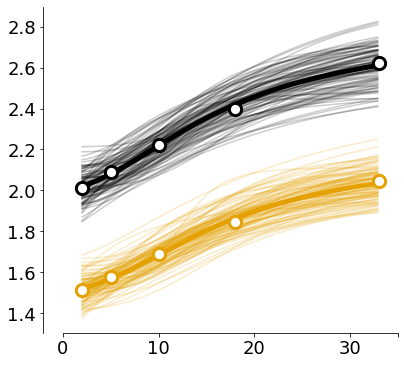

In [67]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (6,6))
cvals = np.arange(0.02,0.33,0.001)
ctrlave = np.zeros(len(cvals))
stimave = np.zeros(len(cvals))
for ti in range(100):
    m_cp, C_cp, n_cp, k_cp, m_sp, C_sp, n_sp, k_sp, m_cs, C_cs, n_cs, k_cs, m_ss, C_ss, n_ss, k_ss = parameter_fits[ti]

    
    yvals = naka_rushton(cvals, m_cs, C_cs, n_cs, k_cs)

    ax.plot(cvals,yvals, c= 'black', alpha=0.2)
    
    ctrlave += yvals
    
    cvals = np.arange(0.02,0.33,0.001)
    yvals = naka_rushton(cvals, m_ss, C_ss, n_ss, k_ss)
    stimave += yvals

    ax.plot(cvals,yvals, c= sstcolor, alpha=0.2)

    
ctrlave = ctrlave/100
stimave = stimave/100
ax.plot(cvals,stimave, c=sstcolor, lw=5)
ax.plot(cvals,ctrlave, c='black', lw=5)
ax.scatter(contrasts, ctrl_sst_ave, edgecolor='black', linewidth=3, s=150, facecolor = 'white', zorder=10)
ax.scatter(contrasts, stim_sst_ave, edgecolor=sstcolor, linewidth=3, s=150, facecolor = 'white', zorder=10)


# ax.set_yticks([1*i for i in range(11)], [0,'',0.1,'',0.2,'',0.3,'',0.4, '',0.5])
# ax.set_ylim(0,9.)
# ax.set_xlim(-0.4,0.4)
ax.set_xlim(0.02,0.33)
ax.set_xticks([0.0,0.1,0.2,0.3,0.35])
ax.set_xticklabels([0,10,20,30,''])
sns.despine(offset={'left':20}, trim=False)


In [45]:
ctrl_sst_ave

array([2.01165548, 2.09174226, 2.22418858, 2.39803367, 2.6246376 ])